# Python Programming Assignment

In [14]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import mahalanobis
from scipy.stats import wilcoxon

In [15]:
df = pd.read_csv("patients.csv")

# Display basic info and first few rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   patient_id           400 non-null    int64
 1   age                  400 non-null    int64
 2   duration             400 non-null    int64
 3   pain                 400 non-null    int64
 4   urgency              400 non-null    int64
 5   nocturnal_frequency  400 non-null    int64
 6   treatment            400 non-null    int64
dtypes: int64(7)
memory usage: 22.0 KB


,patient_id,age,duration,pain,urgency,nocturnal_frequency,treatment
0,0,56,4,7,6,2,1
1,1,69,6,1,2,4,0
2,2,46,8,7,7,5,0
3,3,32,20,6,2,1,1
4,4,60,3,9,0,3,0


In [16]:
# Select covariates for matching
covariates = ["age", "duration", "pain", "urgency", "nocturnal_frequency"]

# Separate treated and control groups
treated = df[df["treatment"] == 1].reset_index(drop=True)
control = df[df["treatment"] == 0].reset_index(drop=True)

# Compute covariance matrix for Mahalanobis Distance
cov_matrix = np.cov(df[covariates].T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Find the closest control for each treated patient
matched_indices = []
for i, row in treated.iterrows():
    dists = control[covariates].apply(lambda x: mahalanobis(row[covariates], x, inv_cov_matrix), axis=1)
    matched_indices.append(dists.idxmin())

# Create matched pairs
matched_control = control.loc[matched_indices].reset_index(drop=True)
matched_treated = treated.copy()

# Combine matched pairs into a new DataFrame
matched_df = pd.concat([matched_treated, matched_control], axis=1, keys=["treated", "control"])
matched_df.head()

treated                                                          \
  patient_id age duration pain urgency nocturnal_frequency treatment   
0          0  56        4    7       6                   2         1   
1          3  32       20    6       2                   1         1   
2          6  78        3    1       2                   5         1   
3          7  38       18    5       1                   4         1   
4          9  75       18    2       2                   3         1   

     control                                                          
  patient_id age duration pain urgency nocturnal_frequency treatment  
0        101  51        5    6       6                   2         0  
1        366  33       18    5       1                   0         0  
2          1  69        6    1       2                   4         0  
3         18  41       14    4       0                   3         0  
4         65  77       15    2       2                   2         0

In [17]:
def standardized_mean_diff(group1, group2, covariates):
    diff = group1[covariates].mean() - group2[covariates].mean()
    pooled_std = np.sqrt((group1[covariates].var() + group2[covariates].var()) / 2)
    return diff / pooled_std

# Check balance before and after matching
before_matching = standardized_mean_diff(treated, control, covariates)
after_matching = standardized_mean_diff(matched_treated, matched_control, covariates)

print("Standardized Mean Differences Before Matching:\n", before_matching)
print("\nStandardized Mean Differences After Matching:\n", after_matching)

Standardized Mean Differences Before Matching:
 age                    0.021621
duration              -0.125677
pain                   0.059195
urgency               -0.121073
nocturnal_frequency   -0.106564
dtype: float64

Standardized Mean Differences After Matching:
 age                   -0.032221
duration               0.013168
pain                   0.038618
urgency               -0.016989
nocturnal_frequency    0.011860
dtype: float64


In [18]:
# Compute the differences in symptom scores
outcome_columns = ["pain", "urgency", "nocturnal_frequency"]

for col in outcome_columns:
    stat, p = wilcoxon(matched_df["treated"][col], matched_df["control"][col])
    print(f"{col}: Wilcoxon Signed-Rank Test statistic = {stat}, p-value = {p}")

pain: Wilcoxon Signed-Rank Test statistic = 3457.0, p-value = 0.167447562039733
urgency: Wilcoxon Signed-Rank Test statistic = 4306.0, p-value = 0.5178315231002557
nocturnal_frequency: Wilcoxon Signed-Rank Test statistic = 2096.0, p-value = 0.6972575084393129


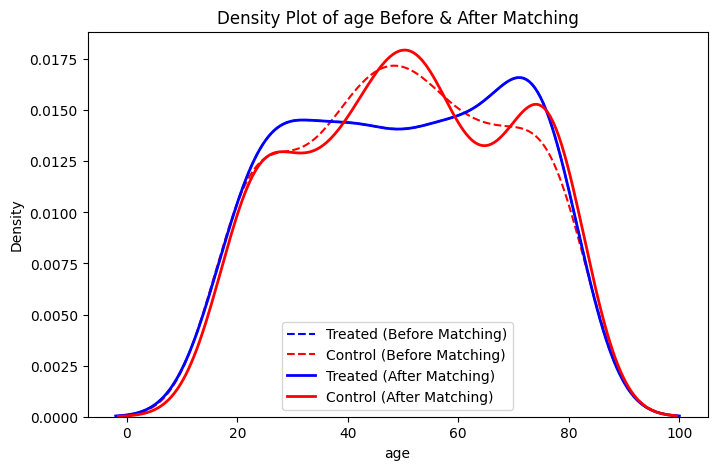

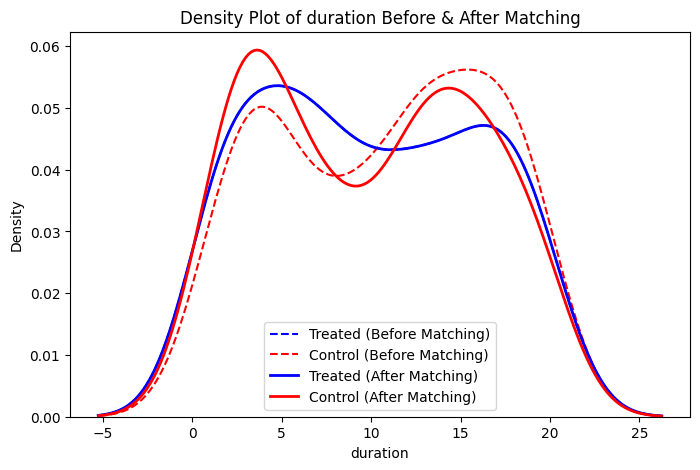

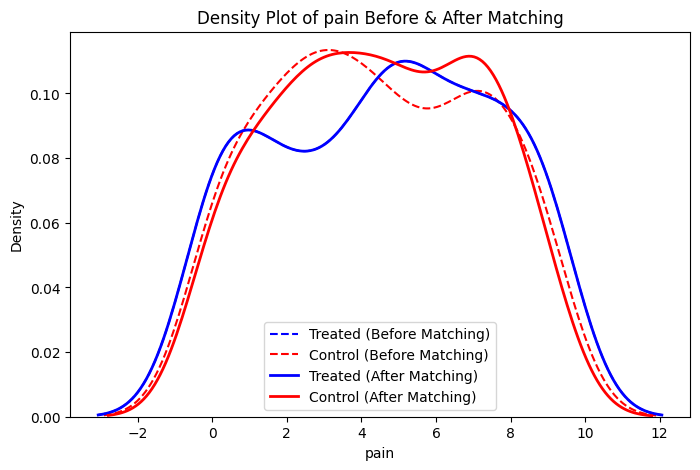

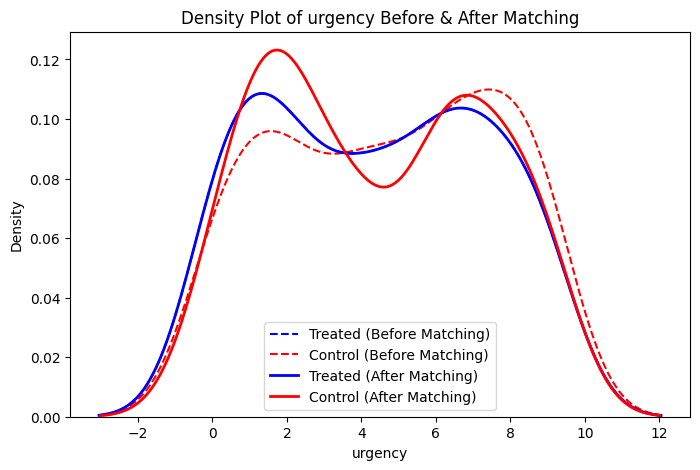

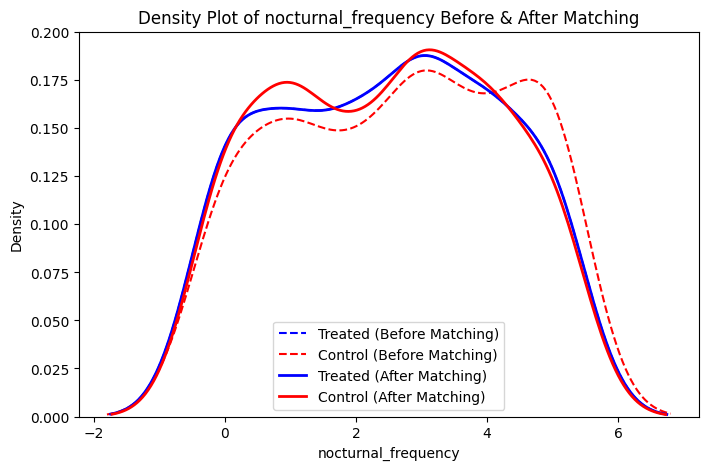

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_covariate_distributions(treated, control, matched_treated, matched_control, covariates):
    for cov in covariates:
        plt.figure(figsize=(8, 5))
        sns.kdeplot(treated[cov], label="Treated (Before Matching)", color="blue", linestyle="--")
        sns.kdeplot(control[cov], label="Control (Before Matching)", color="red", linestyle="--")
        sns.kdeplot(matched_treated[cov], label="Treated (After Matching)", color="blue", linewidth=2)
        sns.kdeplot(matched_control[cov], label="Control (After Matching)", color="red", linewidth=2)

        plt.title(f"Density Plot of {cov} Before & After Matching")
        plt.legend()
        plt.show()

# Call function
plot_covariate_distributions(treated, control, matched_treated, matched_control, covariates)

/var/folders/mp/xz0hrky93l3c48ndxn82fv5c0000gn/T/ipykernel_5620/308342284.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[matched_df["treated"][col], matched_df["control"][col]], palette=["blue", "red"])


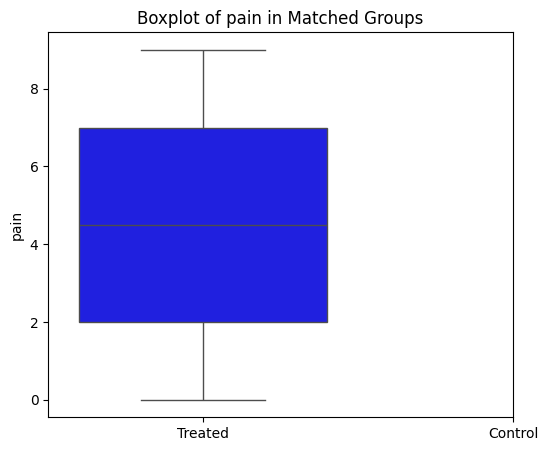

/var/folders/mp/xz0hrky93l3c48ndxn82fv5c0000gn/T/ipykernel_5620/308342284.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[matched_df["treated"][col], matched_df["control"][col]], palette=["blue", "red"])


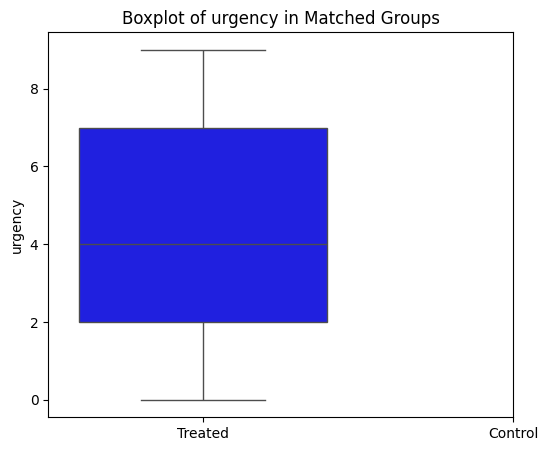

/var/folders/mp/xz0hrky93l3c48ndxn82fv5c0000gn/T/ipykernel_5620/308342284.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[matched_df["treated"][col], matched_df["control"][col]], palette=["blue", "red"])


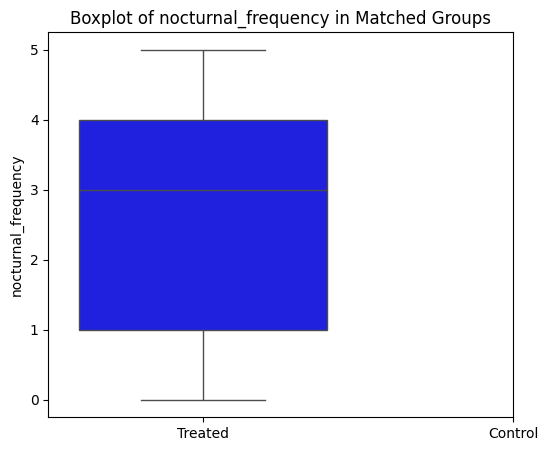

In [21]:
def plot_boxplots(matched_df, outcome_columns):
    for col in outcome_columns:
        plt.figure(figsize=(6, 5))
        sns.boxplot(data=[matched_df["treated"][col], matched_df["control"][col]], palette=["blue", "red"])
        plt.xticks([0, 1], ["Treated", "Control"])
        plt.title(f"Boxplot of {col} in Matched Groups")
        plt.ylabel(col)
        plt.show()

# Call function
plot_boxplots(matched_df, outcome_columns)

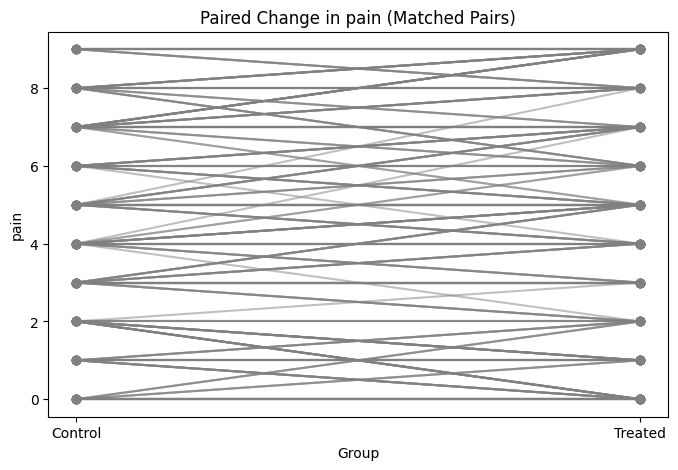

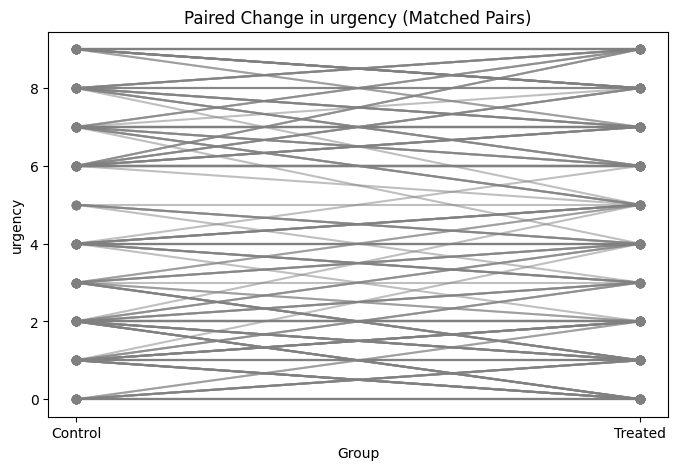

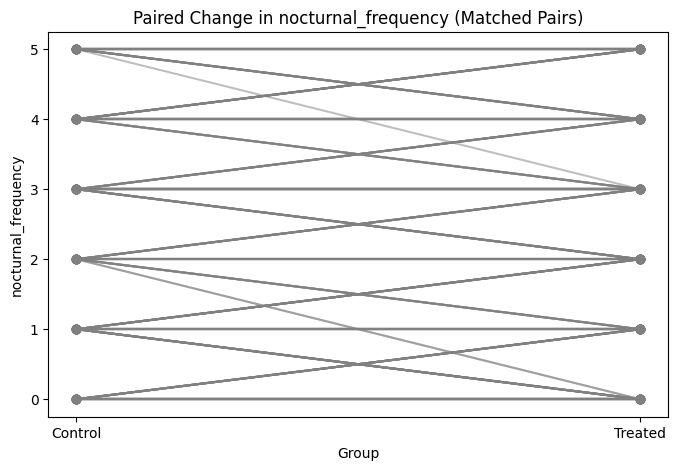

In [22]:
def plot_paired_changes(matched_df, outcome_columns):
    for col in outcome_columns:
        plt.figure(figsize=(8, 5))
        for i in range(len(matched_df)):
            plt.plot(["Control", "Treated"], 
                     [matched_df["control"][col].iloc[i], matched_df["treated"][col].iloc[i]], 
                     marker="o", color="gray", alpha=0.5)
        plt.xlabel("Group")
        plt.ylabel(col)
        plt.title(f"Paired Change in {col} (Matched Pairs)")
        plt.show()

# Call function
plot_paired_changes(matched_df, outcome_columns)

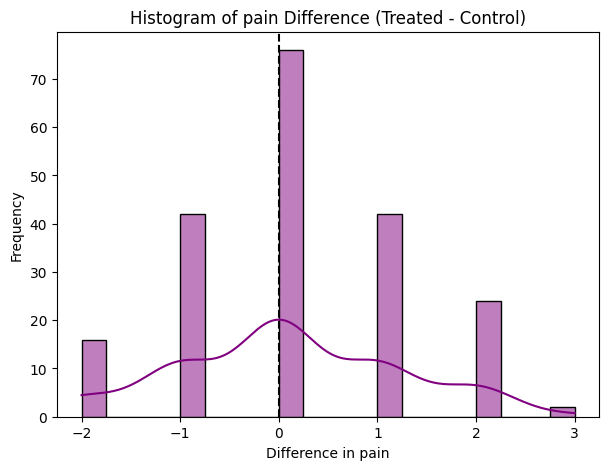

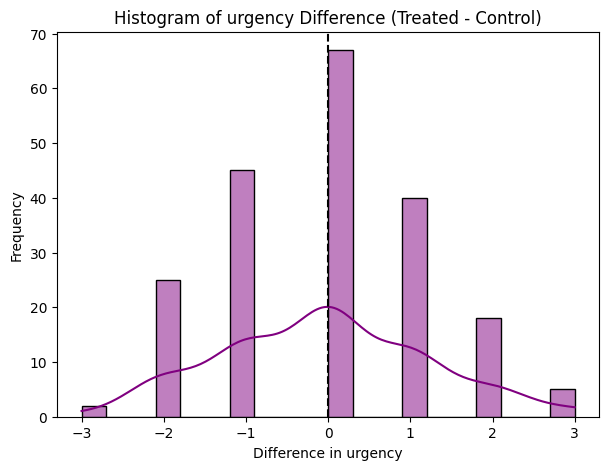

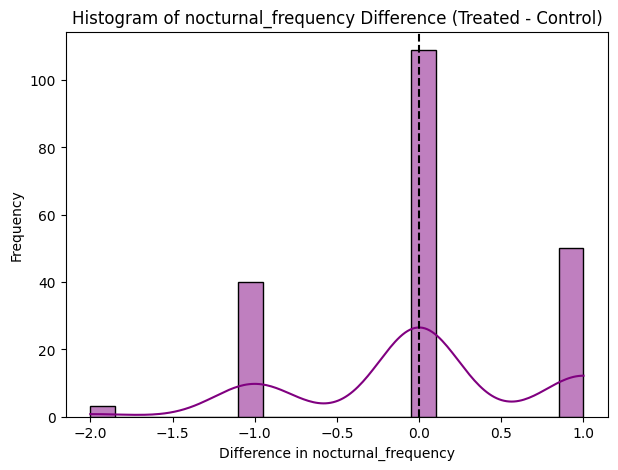

In [23]:
def plot_difference_histograms(matched_df, outcome_columns):
    for col in outcome_columns:
        plt.figure(figsize=(7, 5))
        diff = matched_df["treated"][col] - matched_df["control"][col]
        sns.histplot(diff, bins=20, kde=True, color="purple")
        plt.axvline(0, color="black", linestyle="--")
        plt.title(f"Histogram of {col} Difference (Treated - Control)")
        plt.xlabel(f"Difference in {col}")
        plt.ylabel("Frequency")
        plt.show()

# Call function
plot_difference_histograms(matched_df, outcome_columns)